In [1]:
import asyncio
from time import time

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import xarray
from skimage.filters import threshold_otsu

import sys
import datacube
from datacube.helpers import write_geotiff
from datacube.utils import cog
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datacube.storage import masking

sys.path.append("Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices
from dea_datahandling import wofs_fuser
from dea_dask import create_local_dask_cluster

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:38151 Dashboard: /user/gabrielleh/proxy/8787/status,Cluster Workers: 1 Cores: 8 Memory: 61.42 GB


In [3]:
dc = datacube.Datacube(app="Sentinel_2_burn_ratio")

In [4]:
list(dc.list_products()['name'])

['camden_insar_alos_displacement',
 'fc_percentile_albers_annual',
 'fc_percentile_albers_seasonal',
 'ga_ls5t_ard_3',
 'ga_ls7e_ard_3',
 'ga_ls8c_ard_3',
 'ga_s2a_ard_nbar_granule',
 'ga_s2am_fractional_cover_2',
 'ga_s2b_ard_nbar_granule',
 'ga_s2bm_fractional_cover_2',
 'high_tide_comp_20p',
 'item_v2',
 'item_v2_conf',
 'landsat_barest_earth',
 'low_tide_comp_20p',
 'ls5_ard',
 'ls5_fc_albers',
 'ls5_level1_usgs',
 'ls5_nbart_geomedian_annual',
 'ls5_nbart_tmad_annual',
 'ls5_pq_albers',
 'ls5_usgs_l2c1',
 'ls7_ard',
 'ls7_fc_albers',
 'ls7_level1_usgs',
 'ls7_nbart_geomedian_annual',
 'ls7_nbart_tmad_annual',
 'ls7_pq_albers',
 'ls7_usgs_l2c1',
 'ls8_ard',
 'ls8_barest_earth_albers',
 'ls8_fc_albers',
 'ls8_level1_usgs',
 'ls8_nbart_geomedian_annual',
 'ls8_nbart_tmad_annual',
 'ls8_pq_albers',
 'ls8_usgs_l2c1',
 'mangrove_cover',
 'multi_scale_topographic_position',
 'nidem',
 's1_gamma0_geotif_scene',
 's2a_ard_granule',
 's2a_l1c_aws_pds',
 's2a_level1c_granule',
 's2a_nrt_gran

In [5]:
# Syd
central_lat = -34.558100
central_lon =  150.646049


# Set the buffer to load around the central coordinates
buffer = 0.5

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, crs='EPSG:4326', margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

In [6]:
# Load a fractional cover (FC) tile to match the WOFLs data by using 'like'
# data = dc.load(product="ga_ls8c_ard_3", group_by="solar_day", 
#                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
#                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
#                like=wofls)

# Create a reusable query
query = {
    "x": study_area_lon,
    "y": study_area_lat,
    "time": ('2016-01-01', '2016-12-31'),
    "output_crs": "EPSG:3577",
    "crs":'EPSG:4326',
    "resolution": (-30, 30),
#     "group_by": "solar_day",
#     "fuse_func": wofs_fuser,
}


data = load_ard(dc=dc,
                min_gooddata=0.7,
                products=["ga_ls8c_ard_3"], 
                group_by="solar_day", 
                measurements=['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2'], 
                dask_chunks={"time": 1, "x": 3000, "y": 3000}, 
                **query)
# data

Scripts/dea_datahandling.py:209: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can significantly slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Loading ga_ls8c_ard_3 data
    Filtering to 10 out of 46 observations
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 10 observations as a dask array


In [7]:
data

<xarray.Dataset>
Dimensions:       (time: 10, x: 3556, y: 4117)
Coordinates:
    spatial_ref   int32 3577
  * y             (y) float64 -3.835e+06 -3.835e+06 ... -3.959e+06 -3.959e+06
  * x             (x) float64 1.645e+06 1.645e+06 ... 1.752e+06 1.752e+06
  * time          (time) datetime64[ns] 2016-02-22T23:49:47.565226 ... 2016-1...
Data variables:
    nbart_blue    (time, y, x) float32 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nbart_green   (time, y, x) float32 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nbart_red     (time, y, x) float32 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nbart_nir     (time, y, x) float32 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nbart_swir_1  (time, y, x) float32 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
    nbart_swir_2  (time, y, x) float32 dask.array<chunksize=(1, 3000, 3000), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [14]:
# Create a reusable query
query = {
    "x": study_area_lon,
    "y": study_area_lat,
    "time": ('1970-01-01', '2015-12-31'),
    "output_crs": "EPSG:3577",
    "crs":'EPSG:4326',
    "resolution": (-30, 30),
#     "group_by": "solar_day",
#     "fuse_func": wofs_fuser,
}

data = dc.load(product=["wofs_filtered_summary"], **query)
data

<xarray.Dataset>
Dimensions:                (time: 1, x: 3556, y: 4117)
Coordinates:
  * time                   (time) datetime64[ns] 1970-01-01
  * y                      (y) float64 -3.835e+06 -3.835e+06 ... -3.959e+06
  * x                      (x) float64 1.645e+06 1.645e+06 ... 1.752e+06
    spatial_ref            int32 3577
Data variables:
    confidence             (time, y, x) float32 5.951162e-06 ... 1.0
    wofs_filtered_summary  (time, y, x) float32 -1.0 -1.0 ... 0.97727275
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

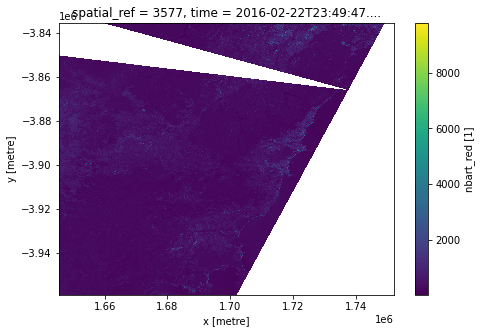

In [7]:
data.nbart_red.isel(time=0).plot(size=5)

In [8]:
cloudfree_data = data

In [9]:
cloudfree_data = calculate_indices( cloudfree_data, 
                          index='TCW', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

cloudfree_data = calculate_indices( cloudfree_data, 
                          index='TCG', 
                          collection='ga_ls_3', 
                          normalise=False,
                          drop=False)

Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "
Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCG') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


In [10]:
# (cloudfree_data.TCG).plot(col="time", cmap='Greens',col_wrap=3)
# plt.show()

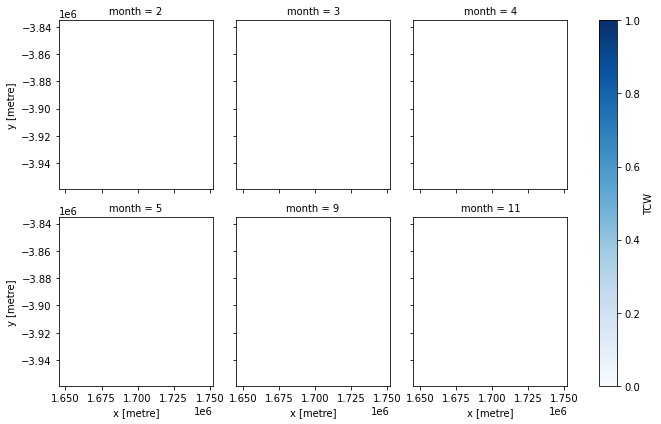

In [11]:
green = cloudfree_data.TCG > 0
wet = cloudfree_data.TCW > -350
not_green= wet.where(green != 1,0,0)

not_green = not_green.groupby('time.month').max(dim='time')  
# not_green = np.where(green.TCG != 1, wet.TCW, 0)
# not_green = (green.TCG != 1) & wet.TCW #green.TCG & wet.TCW
not_green

not_green.plot(col="month", cmap='Blues',col_wrap=3)
plt.show()

In [12]:
tcg = cloudfree_data.isel(time=0).TCG
tcw = cloudfree_data.isel(time=0).TCW

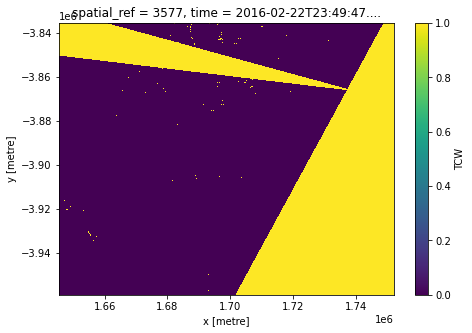

In [13]:
(tcw.isnull()).plot(size=5)

In [14]:
not_green

<xarray.DataArray 'TCW' (month: 6, y: 4117, x: 3556)>
dask.array<stack, shape=(6, 4117, 3556), dtype=int64, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 3577
  * y            (y) float64 -3.835e+06 -3.835e+06 ... -3.959e+06 -3.959e+06
  * x            (x) float64 1.645e+06 1.645e+06 ... 1.752e+06 1.752e+06
  * month        (month) int64 2 3 4 5 9 11

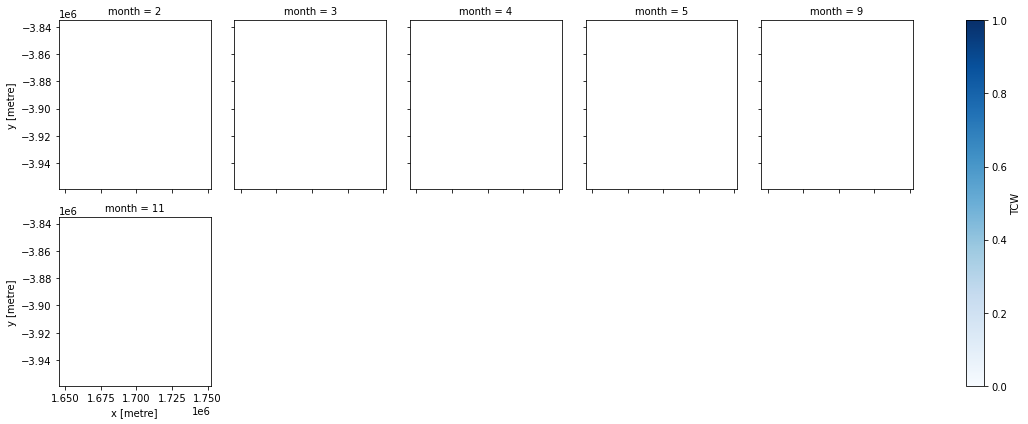

In [15]:
(not_green).plot(col="month", cmap='Blues',col_wrap=5)
plt.show()

In [16]:

%matplotlib widget
def show_widget(tcw, tcg, tile_label, subsample=5, continuous_update=True, mrvbf=False):
#     tcw = tcw#get_tcw(tile_label).isel(band=3)[::subsample, ::subsample]
#     tcg = tcg#get_tcg(tile_label).isel(band=1)[::subsample, ::subsample]
    
    initial_tcw_threshold = -600
    initial_tcg_threshold = 1000
    tcw_mask = tcw > initial_tcw_threshold
#     initial_tcg_threshold = np.percentile(tcg, 95)
    tcg_mask = tcg < initial_tcg_threshold
    
    output = ipywidgets.Output()
    with output:
        fig = plt.figure(figsize=(6, 6))
        gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[1, 1],
                              height_ratios=[1, 0.25], hspace=0.3, bottom=0.03, wspace=0.2,
                              top=0.95)
        ax = fig.add_subplot(gs[0, :])
        im = (tcw_mask & tcg_mask).plot.imshow(interpolation='bilinear', ax=ax)

        hist_ax_tcg = fig.add_subplot(gs[1, 0])
        hist_ax_tcg.set_title('TCG50')
        hist_tcg = hist_ax_tcg.hist(tcg.values.ravel(), bins=100, color='lightgray')
        hist_ax_tcw = fig.add_subplot(gs[1, 1])
        hist_ax_tcw.set_title('TCW95')
        hist_tcw = hist_ax_tcw.hist(tcw.values.ravel(), bins=100, color='lightgray')
        
        hist_line_tcg = hist_ax_tcg.axvline(initial_tcg_threshold, c='green')
        hist_line_tcw = hist_ax_tcw.axvline(initial_tcw_threshold, c='blue')

    def update_masks_and_draw():
        im.set_data(tcw_mask & tcg_mask)
        im.autoscale()
        fig.canvas.draw()
        
    def slider_update_green(change):
        with output:  # for errors
            threshold = change['new']
            if not isinstance(threshold, float):
                return

            nonlocal tcg_mask
            tcg_mask = tcg < threshold
            hist_line_tcg.set_xdata([threshold, threshold])

            update_masks_and_draw()

    def slider_update_wet(change):
        with output:  # for errors
            threshold = change['new']
            if not isinstance(threshold, float):
                return

            nonlocal tcw_mask
            tcw_mask = tcw > threshold
            hist_line_tcw.set_xdata([threshold, threshold])

            update_masks_and_draw()

    slider_props = dict(
        step=10,
        disabled=False,
        continuous_update=continuous_update,
        orientation='horizontal',
        readout=True,
        layout=ipywidgets.Layout(width='50%', margin='0 0 0 0'),
        style={'description_width': 'initial'},
        readout_format='.0f')
    slider_tcg = ipywidgets.FloatSlider(
        min=tcg.min(),
        max=tcg.max(),
        value=initial_tcg_threshold,
        description='Max TCG50:',
        **slider_props)
    slider_tcg.observe(slider_update_green, names='value')
    slider_tcw = ipywidgets.FloatSlider(
        min=tcw.min(),
        max=tcw.max(),
        value=initial_tcw_threshold,
        description='Max TCW95:',
        **slider_props)
    slider_tcw.observe(slider_update_wet, names='value')
    
    return ipywidgets.VBox([output, slider_tcg, slider_tcw])

In [17]:
show_widget(tcw, tcg, '10,-15', subsample=5, continuous_update=True)